In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x',
 'misc.forsale','rec.autos','rec.motorcycles','rec.sport.baseball',
 'rec.sport.hockey','sci.crypt','sci.electronics','sci.med','sci.space',
 'soc.religion.christian','talk.politics.guns','talk.politics.mideast',
 'talk.politics.misc','talk.religion.misc'
]

twenty_train = fetch_20newsgroups(subset='train', categories = categories, shuffle= True, random_state=42)
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
# 트레이닝 데이터 수 확인

print(f'{len(twenty_train.data) = }')
print(f'{len(twenty_train.filenames) = }')

len(twenty_train.data) = 11314
len(twenty_train.filenames) = 11314


In [4]:
# 트레이닝 데이터 문서 확인, 카테고리 확인  

print("\n".join(twenty_train.data[-1].split('\n')[:3]), end='\n\n') # 3번째 문장까지 출력
print(twenty_train.target_names[twenty_train.target[-1]], end='\n\n')
print(f'{twenty_train.target[:10] = }') 

From: gunning@cco.caltech.edu (Kevin J. Gunning)
Subject: stolen CBR900RR
Organization: California Institute of Technology, Pasadena

rec.motorcycles

twenty_train.target[:10] = array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4], dtype=int64)


In [5]:
# 트레이닝 데이터를 카운트 벡터로 변환하고 전체 행렬 크기 확인 

from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(twenty_train.data)
x_train_counts.shape

(11314, 130107)

In [6]:
# 카운트 벡터 행렬을 Tf-idf 행렬로 변환하고 전체 행렬 크기 확인 

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tf = tfidf_transformer.fit_transform(x_train_counts)
X_train_tf.shape 

(11314, 130107)

In [7]:
# 트레이닝 데이터로 나이브 베이즈 모델 학습

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tf, twenty_train.target)

In [8]:
# 학습된 모델에 임의의 데이터를 입력하고 분류 결과 확인

docs_new = ['I need to purchase a Telephone', 'OpenGL on the GPU is fast']

x_new_counts = count_vect.transform(docs_new)
x_new_tfidf = tfidf_transformer.transform(x_new_counts)
predicted = clf.predict(x_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'I need to purchase a Telephone' => sci.crypt
'OpenGL on the GPU is fast' => rec.autos


In [10]:
# 파이프라인 생성, 파이프라인을 통해 트레이닝 데이터로 모델 학습

from sklearn.pipeline import Pipeline

text_clf = Pipeline([ 
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [11]:
# 테스트 데이터를 분류하고 정확도 확인

import numpy as np
from sklearn import metrics

twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)

accuracy = np.mean(predicted == twenty_test.target)
print(f'the accuracy is {accuracy:.3f}')
bd_accuracy = metrics.balanced_accuracy_score(predicted, twenty_test.target)
print(f'the balanced accuracy is {bd_accuracy:.3f}')

the accuracy is 0.774
the balanced accuracy is 0.826


Text(442.65312500000005, 0.5, 'predicted categories')

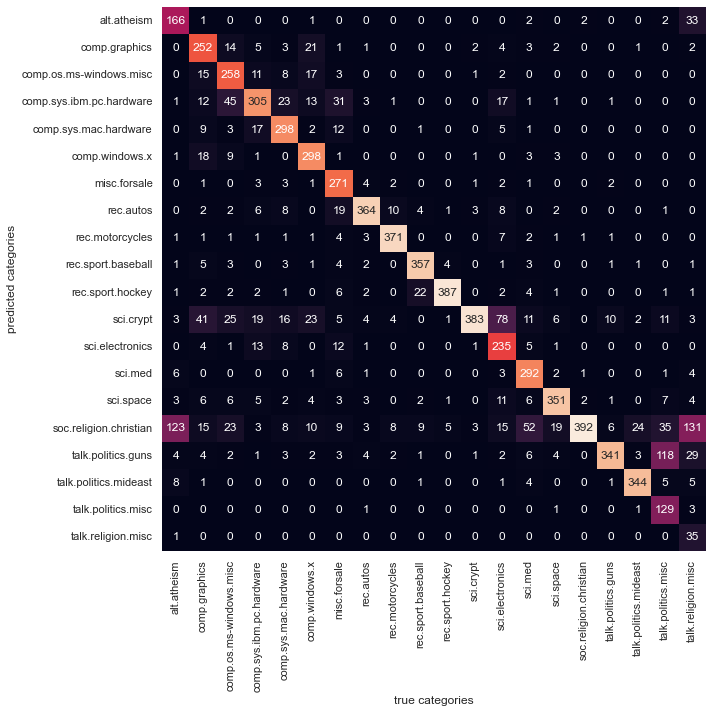

In [12]:
# confusion matrix, heat map 생성

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc = {'figure.figsize':(20,10)})

mat = confusion_matrix(twenty_test.target, predicted)

sns.heatmap(mat.T, square=True, annot=True, fmt='d',
cbar=False, xticklabels = twenty_train.target_names,
yticklabels= twenty_train.target_names)

plt.xlabel('true categories')
plt.ylabel('predicted categories')

In [13]:
# SGDClassifier 모델을 사용하여 파이프라인 생성, 파이프라인을 통해 트레이닝 데이터로 모델 학습

from sklearn.linear_model import SGDClassifier

text_clf = Pipeline([
    ('vect',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('clf',SGDClassifier(loss='hinge', penalty='L2',
    alpha=1e-3, random_state=42,
    max_iter=5, tol=None))    
])

text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, penalty='L2',
                               random_state=42, tol=None))])

In [14]:
# 테스트 데이터를 분류하고 정확도 확인

predicted = text_clf.predict(docs_test)

accuracy = np.mean(predicted == twenty_test.target)
print(f'the accuracy is {accuracy:.3f}')
bd_accuracy = metrics.balanced_accuracy_score(predicted, twenty_test.target)
print(f'the balanced accuracy is {bd_accuracy:.3f}')

the accuracy is 0.825
the balanced accuracy is 0.828


Text(442.65312500000005, 0.5, 'predicted categories')

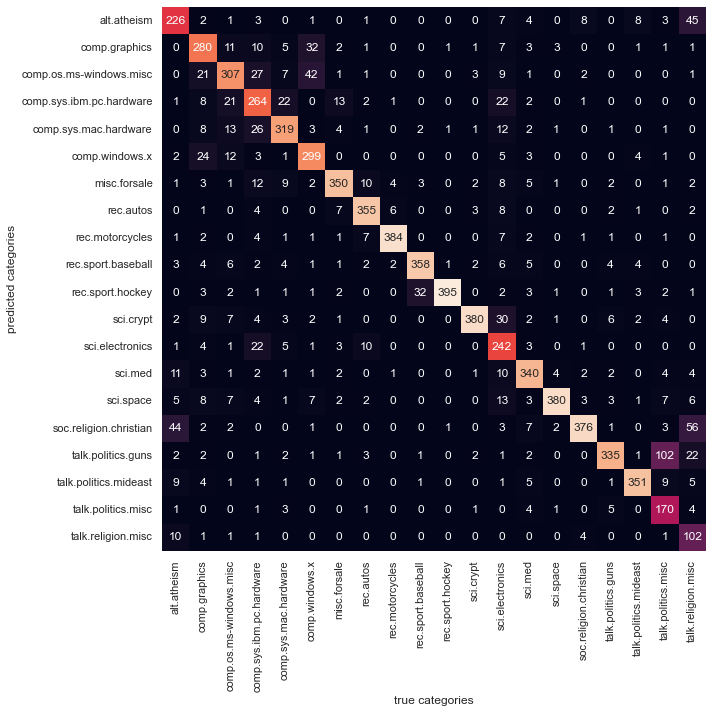

In [15]:
# confusion matrix, heat map 생성

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc = {'figure.figsize':(20,10)})

mat = confusion_matrix(twenty_test.target, predicted)

sns.heatmap(mat.T, square=True, annot=True, fmt='d',
cbar=False, xticklabels = twenty_train.target_names,
yticklabels= twenty_train.target_names)

plt.xlabel('true categories')
plt.ylabel('predicted categories')